# A Basic Model

In [8]:
import ISOSIMpy as ism
import numpy as np
import matplotlib.pyplot as plt

## 1. Generate Synthetic Observation Data

In [85]:
# make reproducible
np.random.seed(42)

### define input series
# define time steps
timesteps = np.arange(0.0, 50.0 * 12.0, 1.0) # 50 years of monthly values

# this represents the tracer input to the aquifer
# we start with a constant input of 1.0
input_series = np.ones(len(timesteps))
# we add a pulse of higher tracer input during some years, similar to the
# increase in tritium in the atmosphere
# this is just a bell-shaped pulse
offset = 120.
scale = - 0.0004 # negative; closer to zero means wider pulse
input_series += np.exp(scale * ((timesteps - offset) ** 2))
# add some noise to the data
input_series += np.random.normal(0.0, 0.03, len(input_series))

In [86]:
### define model (the true system; in practice we don't know this)
# get decay constant
# we assume a half life of 12.3 years
t_half = 12.3 * 12.0
lambda_ = np.log(2.0) / t_half

# create true observations using the model
# time step is 1 month
m = ism.model.Model(
    dt=1.0,
    lambda_=lambda_,
    input_series=input_series,
    steady_state_input=1.,
    n_warmup_half_lives=10
)

# add an exponential-piston-flow unit
# define the true model parameters
mtt_true = 12 * 17 # 17 years
eta_true = 1.5
m.add_unit(
    ism.model.EPMUnit(mtt=mtt_true, eta=eta_true),
    fraction=1.,
    prefix="epm"
)

true_params = m.params

# simulate
output_series = m.simulate()

In [87]:
# make reproducible
np.random.seed(42)

# define observations
# randomly select a number of observations from the output series
n_obs = 10
obs_idx = np.random.choice(len(timesteps), n_obs)
# select the corresponding timesteps and values
obs_timesteps = timesteps[obs_idx]
obs_values = output_series[obs_idx]
# add some noise to the observations (observation error)
obs_values += np.random.normal(0.0, 0.01, n_obs)

# make series we can later use in the model (has to be the same length as
# the input series, filled with NaN-values where we do not have any
# observations)
obs_series = np.full(len(input_series), np.nan)
obs_series[obs_idx] = obs_values

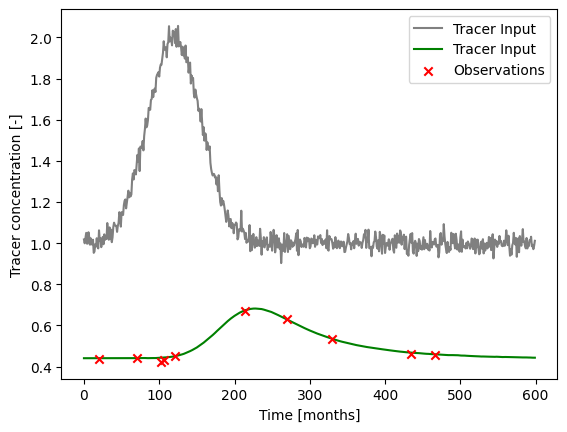

In [88]:
### plot input series, output series, and observations

# create figure
fig, ax = plt.subplots(1, 1)
# plot input series
ax.plot(
    timesteps,
    input_series,
    label="Tracer Input",
    c="grey"
)
# plot output series
ax.plot(
    timesteps,
    output_series,
    label="Tracer Input",
    c="green"
)
# plot observations
ax.scatter(
    obs_timesteps,
    obs_values,
    label="Observations",
    color="red",
    marker="x",
    zorder=10
)
ax.set_xlabel("Time [months]")
ax.set_ylabel("Tracer concentration [-]")
ax.legend()
plt.show()

## 2. Calibrate Model

In [89]:
### define model (use the same structure / units as the true model)
# time step is 1 month
m = ism.model.Model(
    dt=1.0,
    lambda_=lambda_,
    input_series=input_series,
    target_series=obs_series, # now we have a target series
    steady_state_input=1.,
    n_warmup_half_lives=10
)

# add an exponential-piston-flow unit
# define the initial model parameters for inference
mtt_init = 12 * 10 # 17 years
eta_init = 1.1
m.add_unit(
    ism.model.EPMUnit(mtt=mtt_init, eta=eta_init),
    fraction=1.,
    bounds=[(1.0, 12.0 * 45.), (1.0, 3.0)],
    prefix="epm"
)

# create a solver
solver = ism.model.Solver(m)
# run solver
sol, sim = solver.solve(maxiter=1000, popsize=10)

True parameters: [204.0, 1.5]
Calibrated parameters: [204.36143614778004, 1.5439652738495657]


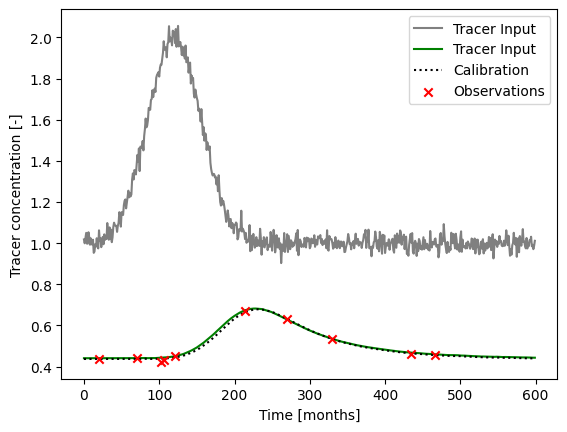

In [100]:
### analyze calibration results
# print optimized parameters
print("True parameters:",
      [true_params[key]["value"] for key in true_params.keys()])
print("Calibrated parameters:",
      [sol[key] for key in sol.keys()])

### plot input series, true output series, observations, and´
# calibrated output

# create figure
fig, ax = plt.subplots(1, 1)
# plot input series
ax.plot(
    timesteps,
    input_series,
    label="Tracer Input",
    c="grey"
)
# plot output series
ax.plot(
    timesteps,
    output_series,
    label="Tracer Input",
    c="green"
)
# plot calibrated results
ax.plot(
    timesteps,
    sim,
    label="Calibration",
    c="black",
    ls=":"
)
# plot observations
ax.scatter(
    obs_timesteps,
    obs_values,
    label="Observations",
    color="red",
    marker="x",
    zorder=10
)
ax.set_xlabel("Time [months]")
ax.set_ylabel("Tracer concentration [-]")
ax.legend()
plt.show()